In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd

#parameters are [A(0), I(0), gamma0, gamma1, nu, beta0, beta1, beta2, u(t) vars]
#consts are [dayNum, I[0], maxI, len(u(t))]

#A' = (b0 / (1 + (b1 * I)**(b2 * u(t)) ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(8 + consts[-1])
        
    params[0] = 10e-10 + random.random()*.1 #A(0), between 0 and 10 percent of the population
    params[1] = 10e-10 + random.random()*.0000001 #I(0), between 0 and .1 percent of the population, avoid 0
    
    params[2] = .1 + random.random()*.4 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .005 + random.random()*.1 #gamma1, asympt->infected
    
    params[4] = .001 + random.random()*.03 #nu, infected -> recov or dead

    params[5] = .5 + random.random()*.2 #beta0, ceiling infectRate - floor infect rate
    params[6] = 50 + 100*random.random() #beta2, scaler on feedback
    params[7] = .5 + random.random()*5 #beta3, exponential [.5, 5.5]
    
    #beta1 = (b0/gamma0 - 1)**(1/u(t)*b2) / maxI, assume u(t) makes a minor difference here
    #params[6] = ((params[5]/params[2])-1)**(1/(params[7])) / consts[2]
    
    for i in range(consts[-1]): #random polynomials
        params[8+i] = .00000001 + (random.random()-.5)*.0001 #very small, but nonzero
    
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    beta = params[5:8]

    #print(params)
    
    u = np.ones((dayNum)) #u(t)
    for t in range(len(u)):
        for expon in range(0, consts[-1]): #polynomial exponent
            u[t] = u[t] + params[8 + expon]*(t**(expon+1)) #i.e. 1 + at + bt^2 ..., 0th power not needed
    
    #print(params)
    
    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def constrainFunc(parameters, consts):
    
    params = np.copy(parameters)

    #fill the constraints
    paramConstraints = np.zeros((len(params),2)) #min, max for each one
    
    paramConstraints[0] = [.0000000001, .5] #A(0)
    paramConstraints[1] = [ 0.000000001, .25] #I(0)

    paramConstraints[2] = [0.00001, parameters[5]] #gamma0, has to be less than ceiling infection rate
    paramConstraints[3] = [0.00001, .9] #gamma1
    
    paramConstraints[4] = [0.00001, .9] #nu

    paramConstraints[5] = [.1, 100] #beta0, beta ceiling
    paramConstraints[6] = [.1, 100000] #beta1, feedback scaling
    paramConstraints[7] = [.25, 10] #beta2
    
    for i in range(consts[-1]): #the polynomials
        paramConstraints[8+i] = [-1, 1] #polynomial bounding
        #paramConstraints[8+i] = [.000000001, .000000002]
    
    for i in range(len(params)): #exercise each constraint
        params[i] = min( max(paramConstraints[i,0], params[i]) , paramConstraints[i,1])
    
    return params

def graphParams(params, consts):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(A, color="orange")
    ax.plot(I, color="red")
    return fig, ax

In [2]:
randomIterCount = 50
quickRunIters = 25 #how many interations on the first convergance
lastRunIters = 500
beginEta = .01 #large learnin rate for quick converging
finalEta = .01
polyNum = 2

## Italy

<ipython-input-1-79bc3ecd9483>:69: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


1 New best error:  0.012998229585522634
11 New best error:  0.01143813134089855
16 New best error:  0.009245742563588455
45 New best error:  0.0086424877270708
Startin Vars:
Error: 0.0086424877270708
[2.98816884e-02 6.89368037e-08 4.92697293e-01 6.51626395e-02
 2.36114868e-02 6.68136985e-01 7.03615383e+01 1.92642919e+00
 4.31293291e-05 1.08066346e-05]


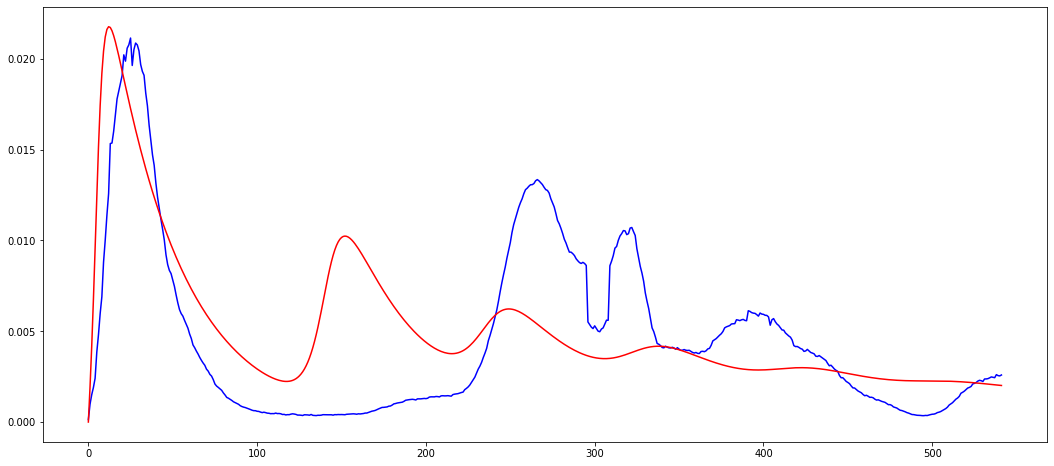

In [3]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy") 

consts = [len(I), I[0], max(I), polyNum]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

italyParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

In [64]:
print(gradDesc.params)

[ 1.23819852e-02  9.31515999e-05  3.82609096e-01  1.96685804e-02
  1.41117591e-02  5.47005795e-01  3.79874674e+01  3.84416509e+00
 -4.90773773e-03]


## US

<ipython-input-1-79bc3ecd9483>:69: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  0.04231122894249765
1 New best error:  0.009634370733737506
40 New best error:  0.009172857839290435
Startin Vars:
Error: 0.009172857839290435
[4.51599902e-02 1.44643592e-08 3.44302437e-01 6.76260766e-03
 2.92090286e-02 6.83125322e-01 1.40492393e+02 3.50605835e+00
 4.98622073e-05 6.13423416e-07]


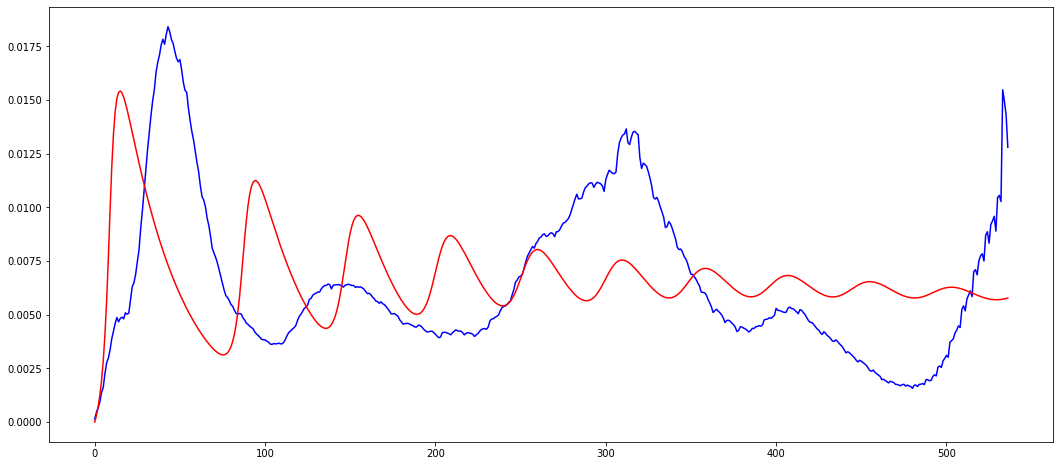

In [5]:
dates, I, R, D, V = owid.LoadCountryNormal("United States") 

consts = [len(I), I[0], max(I), polyNum]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

usParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## UK

0 New best error:  0.06275556063580907


<ipython-input-1-79bc3ecd9483>:69: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


19 New best error:  0.051017998343102056
35 New best error:  0.0501945582711947
37 New best error:  0.04801824080435501
41 New best error:  0.04423819016599216
Startin Vars:
Error: 0.04423819016599216
[ 7.42298607e-02  7.98157622e-08  2.49225626e-01  1.03480840e-01
  2.41749952e-02  6.00622795e-01  1.33762251e+02  4.85166632e+00
 -6.11490364e-06  1.59841947e-05]


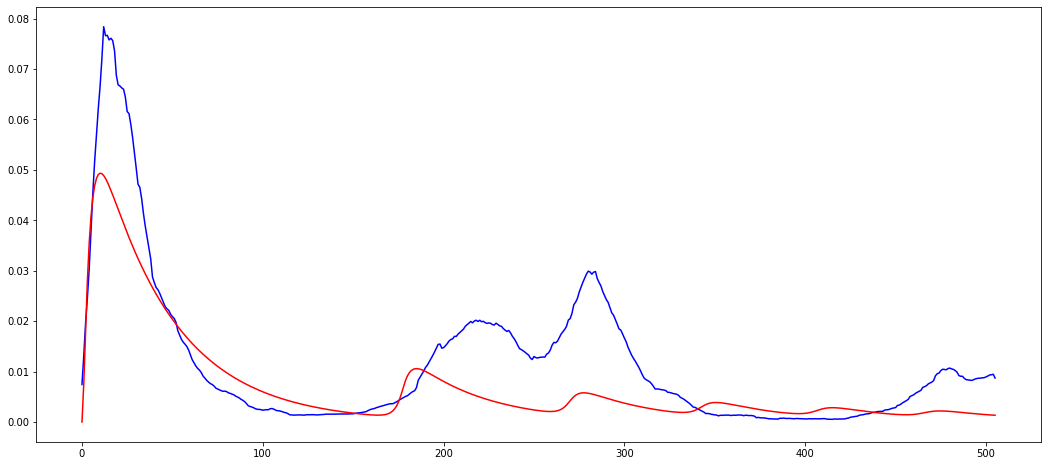

In [6]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom") 

consts = [len(I), I[0], max(I), polyNum]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

ukParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## Canada

0 New best error:  0.003950978503793454


<ipython-input-1-79bc3ecd9483>:69: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


15 New best error:  0.003726420276872326
26 New best error:  0.002539943054165012
Startin Vars:
Error: 0.002539943054165012
[1.18730143e-02 1.00000000e-09 4.30056901e-01 6.09305969e-03
 2.49539554e-02 5.61248809e-01 1.02984362e+02 4.21739129e+00
 5.01505755e-05 2.65033914e-03]


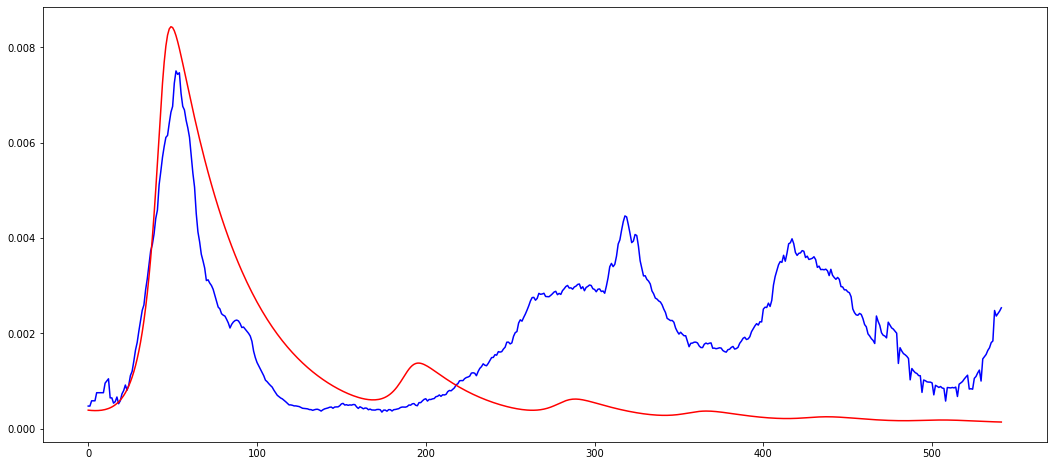

In [7]:
dates, I, R, D, V = owid.LoadCountryNormal("Canada") 

consts = [len(I), I[0], max(I), polyNum]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

canadaParams = gradDesc.params

gradDesc.x = gradDesc.simulate(gradDesc.params)

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## Mexico

0 New best error:  0.022942018835265563


<ipython-input-1-79bc3ecd9483>:69: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


3 New best error:  0.004744624176558851
16 New best error:  0.0016883731933622242
44 New best error:  0.0015157360933981405
Startin Vars:
Error: 0.0015157360933981405
[ 1.00000000e-10  1.18551611e-06  3.45618281e-01  3.67521850e-02
  3.07825888e-02  5.39068797e-01  1.41546184e+02  3.74067320e+00
 -4.21747076e-05  1.03738042e-04]


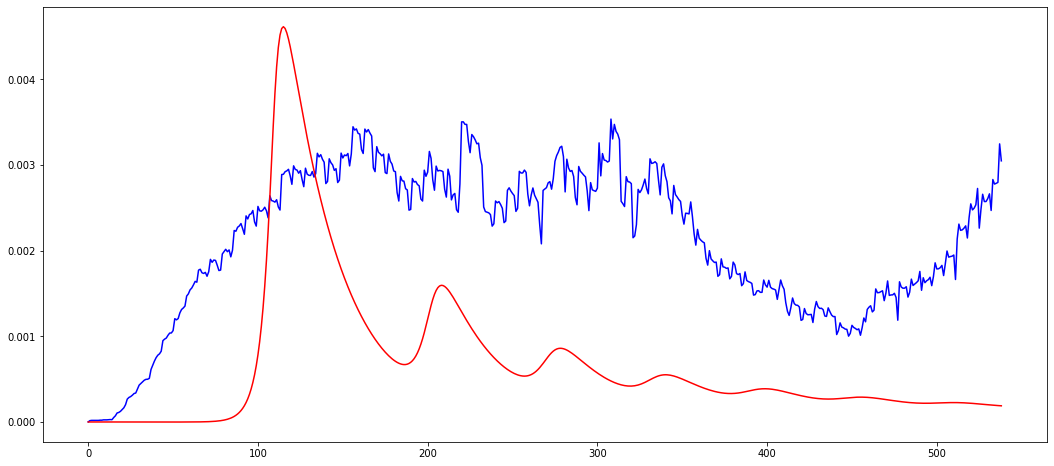

In [8]:
dates, I, R, D, V = owid.LoadCountryNormal("Mexico") 

consts = [len(I), I[0], max(I), polyNum]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

mexicoParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## Israel

<ipython-input-1-79bc3ecd9483>:69: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  0.10181085355741704
2 New best error:  0.05901489592142002
3 New best error:  0.05217028829446489
13 New best error:  0.02830635199970042
32 New best error:  0.027220585988896876
Startin Vars:
Error: 0.027220585988896876
[4.41862382e-03 9.25603017e-04 3.84227419e-01 2.49440845e-02
 1.19904940e-03 6.35746939e-01 9.91432343e+01 5.23392040e+00
 2.56566012e-04 3.44513457e-03]


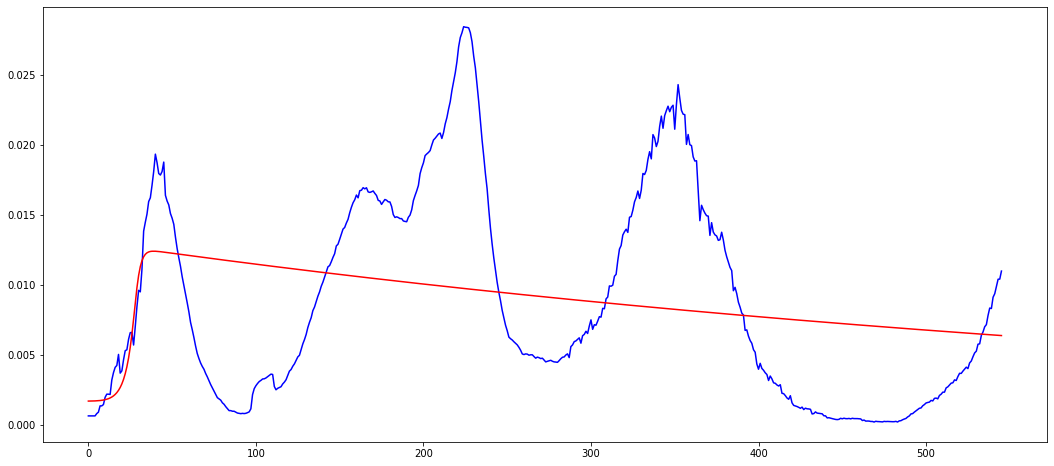

In [9]:
dates, I, R, D, V = owid.LoadCountryNormal("Israel") 

consts = [len(I), I[0], max(I), polyNum]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

israelParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

In [10]:
#dates, I, R, D, V = owid.LoadCountryNormal("Mexico") 
#fig, ax = plt.subplots(figsize=(18,8))
#ax.plot(I)

## Russia

0 New best error:  0.0034205357950176122


<ipython-input-1-79bc3ecd9483>:69: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


12 New best error:  0.002526591382357952
Startin Vars:
Error: 0.002526591382357952
[1.00000000e-10 4.25014408e-05 2.98221495e-01 5.31004931e-02
 1.36029474e-02 5.94082630e-01 9.09768747e+01 1.88409754e+00
 2.63467486e-04 8.99857018e-02]


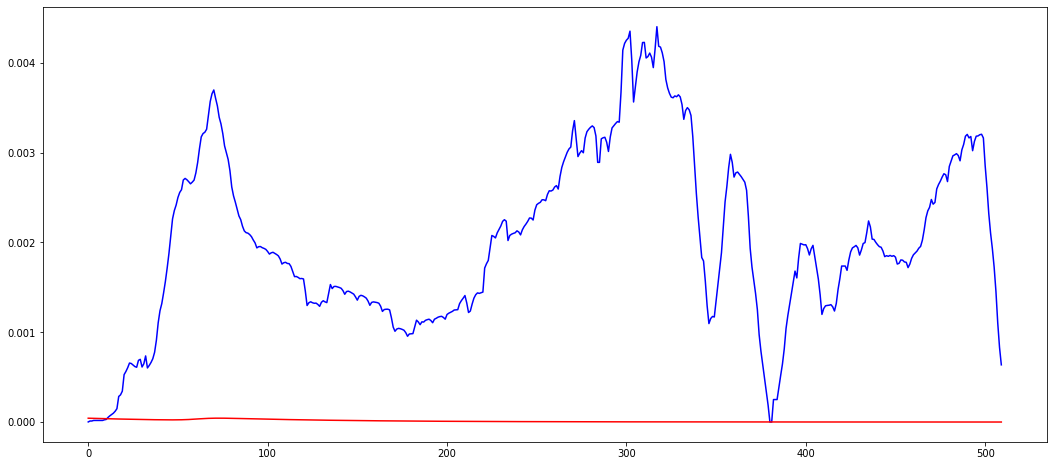

In [11]:
dates, I, R, D, V = owid.LoadCountryNormal("Russia") 

consts = [len(I), I[0], max(I), polyNum]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

russiaParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## South Africa

<ipython-input-1-79bc3ecd9483>:69: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


2 New best error:  0.015554707504334615
5 New best error:  0.015108185018884565
15 New best error:  0.004858146681073333
Startin Vars:
Error: 0.004858146681073333
[4.48544394e-03 1.77271738e-03 1.92842778e-01 6.70326641e-03
 1.78493470e-02 6.70722716e-01 6.11626190e+01 1.13349783e+00
 2.21531659e-03 2.72311425e-01]


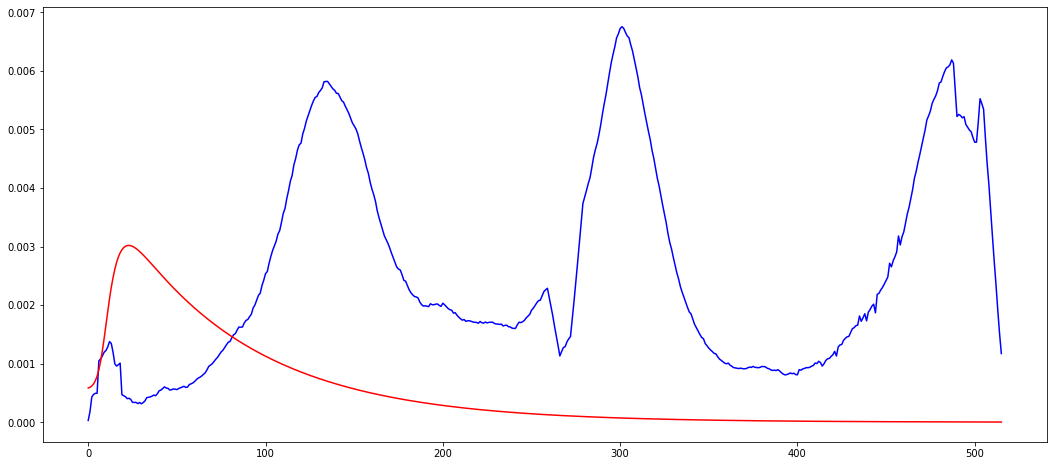

In [12]:
dates, I, R, D, V = owid.LoadCountryNormal("South Africa") 

consts = [len(I), I[0], max(I), polyNum]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

southAfricaParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## Australia

<ipython-input-1-79bc3ecd9483>:69: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


2 New best error:  0.01467138572764499
3 New best error:  0.009216727665629264
8 New best error:  0.004569610514664109
16 New best error:  0.0015257761087970557
36 New best error:  0.0009239152973961502
42 New best error:  1.6258714104677435e-05
Startin Vars:
Error: 1.6258714104677435e-05
[1.00000000e-10 4.20318512e-04 4.45022588e-01 6.27458380e-02
 8.66427390e-03 5.91367917e-01 1.27647843e+02 4.07315007e+00
 1.89076602e-04 4.99012314e-03]


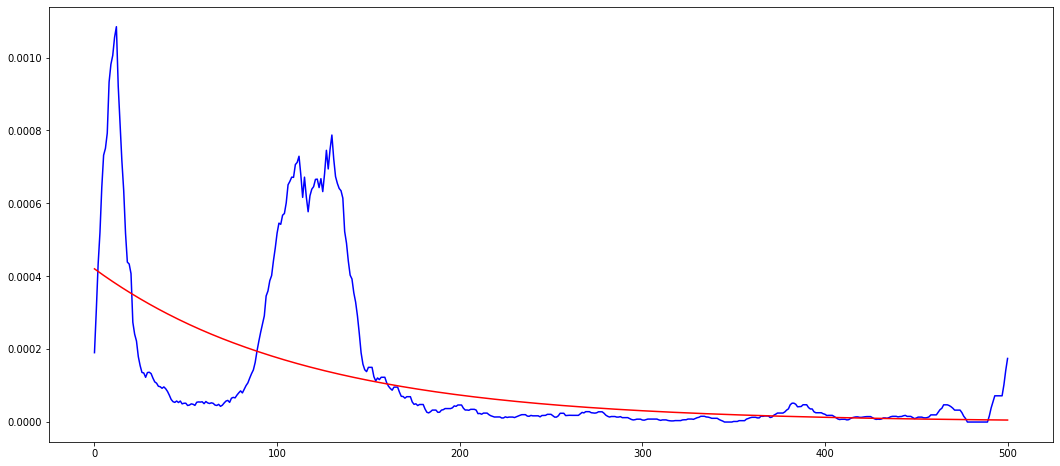

In [13]:
dates, I, R, D, V = owid.LoadCountryNormal("Australia") 

consts = [len(I), I[0], max(I), polyNum]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

australiaParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

## Turkey

In [ ]:
dates, I, R, D, V = owid.LoadCountryNormal("Turkey") 

consts = [len(I), I[0], max(I), polyNum]

gradDesc = gd.GradDescent(I, consts, startFunc, simFunc, constrainFunc)

bestError = 100
gradDesc.eta = beginEta
    
for i in range(randomIterCount):
    gradDesc.solveVars(printOut=0, maxIteration=quickRunIters)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        savedVars = gradDesc.params
        print(i, "New best error: ", bestError)

gradDesc.eta = finalEta
gradDesc.solveVars(params=savedVars, printOut=1000, maxIteration=lastRunIters)

turkeyParams = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(gradDesc.y, color="blue")
ax.plot(gradDesc.x, color="red")

0 New best error:  0.010757338981895747


<ipython-input-1-79bc3ecd9483>:69: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (u[t]*beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


14 New best error:  0.00635114724218637
17 New best error:  0.005909586666940805
27 New best error:  0.0057660338089644755
42 New best error:  0.0050417783844380944
Startin Vars:
Error: 0.0050417783844380944
[4.07687790e-03 9.56991856e-04 3.35315436e-01 8.97438744e-02
 5.83299462e-03 5.77510447e-01 1.10806747e+02 3.89733637e+00
 8.08348671e-04 1.40391141e-01]


In [2]:
#params = startFunc(consts)
#paramsOrig = params.copy()
print(paramsOrig)

params[0] = .03
params[1] = 0

params[2] = .3
params[3] = .01
params[4] = .01
params[-2] = 60
params[-1] = 2

fig, ax = graphParams(params, consts)

ax.plot(I, color="blue")

ax.set_ylim([0, .02])

NameError: name 'paramsOrig' is not defined